<a href="https://colab.research.google.com/github/cgbas/tc-data-analytics/blob/feature%2Ffase2/fase%202/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo preditivo Ibovespa

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base  de dados contida no [Site da Investing](!https://br.investing.com/indices/bovespa-historical-data) e selecione o período diário, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%)

_Dica: utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo._

### Coleta e Tratamento dos dados

Consideraremos dados desde o primeiro dia do plano real (01/07/1994) em nossa análise preliminar, inclusive para entender a ocorrência de outliers desde a introdução de nossa moeda corrente.



In [140]:
#bibliotecas que vamos usar neste estudo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [141]:
df_ibovespa = pd.read_csv('/content/DadosHistoricosIbovespa_de_1995_ate_2024.csv', dtype=str) #importando os dados, importamos tudo como string para evitar perder os 0 (a esquerda e direita) dos números.
df_ibovespa.head() #verificando os dados

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30.06.2010,60.936,61.972,62.645,60.936,"1,96M","-1,68%"
1,29.06.2010,61.978,64.216,64.216,61.670,"2,20M","-3,50%"
2,28.06.2010,64.225,64.825,65.105,64.225,"943,30K","-0,92%"
3,25.06.2010,64.824,63.937,64.869,63.806,"1,26M","1,39%"
4,24.06.2010,63.937,65.154,65.154,63.736,"1,79M","-1,88%"


In [142]:
#Excluindo a coluna que não vamos usar para a análise
df_ibovespa.drop(columns=['Var%'], inplace=True)

#Renomeando as colunas restantes, para não termos problemas com funções futuras (pois tem acentos)
df_ibovespa.columns = ['Data', 'Fechamento', 'Abertura', 'Maxima', 'Minima', 'VolumeNegociado']
df_ibovespa.head() #verificando sucesso das alterações

,Data,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
0,30.06.2010,60.936,61.972,62.645,60.936,"1,96M"
1,29.06.2010,61.978,64.216,64.216,61.670,"2,20M"
2,28.06.2010,64.225,64.825,65.105,64.225,"943,30K"
3,25.06.2010,64.824,63.937,64.869,63.806,"1,26M"
4,24.06.2010,63.937,65.154,65.154,63.736,"1,79M"


In [143]:
#Alterando os tipos dos dados
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa['Data'], format='%d.%m.%Y') # Convertendo a coluna "Data" para o tipo datetime
df_ibovespa['Fechamento'] = df_ibovespa['Fechamento'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Abertura'] = df_ibovespa['Abertura'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Maxima'] = df_ibovespa['Maxima'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['Minima'] = df_ibovespa['Minima'].str.replace('.', '').astype(int) # Convertendo a coluna para o tipo inteiro
df_ibovespa['VolumeNegociado'] = df_ibovespa['VolumeNegociado'].str[:-1].str.replace(',', '.').astype(float) * df_ibovespa['VolumeNegociado'].str[-1:].map({'K':1000, 'M':1000000, 'B':1000000000}) #Convertendo de texto para número
df_ibovespa.head() #verificando o resultado

,Data,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
0,2010-06-30,60936,61972,62645,60936,1960000.0
1,2010-06-29,61978,64216,64216,61670,2200000.0
2,2010-06-28,64225,64825,65105,64225,943300.0
3,2010-06-25,64824,63937,64869,63806,1260000.0
4,2010-06-24,63937,65154,65154,63736,1790000.0


# Análise exploratória

In [144]:
#Verificando a quantidade de linhas que temos para a análise (linhas, colunas)
df_ibovespa.shape

(7439, 6)

In [145]:
#estatísticas básicas do nosso dataframe
df_ibovespa.describe()

,Data,Fechamento,Abertura,Maxima,Minima,VolumeNegociado
count,7439,7439.000000,7439.000000,7439.000000,7439.000000,7.438000e+03
mean,2009-07-12 22:56:07.226777856,50111.120177,50095.360532,50600.950262,49595.968813,1.597423e+09
min,1994-07-04 00:00:00,2138.000000,2138.000000,2449.000000,2110.000000,1.121000e+05
25%,2002-01-12 12:00:00,14047.500000,14048.000000,14219.500000,13854.500000,3.560000e+06
50%,2009-07-13 00:00:00,50518.000000,50511.000000,51171.000000,50005.000000,1.150000e+07
75%,2017-01-14 12:00:00,68618.500000,68607.500000,69304.500000,68026.500000,2.760725e+08
max,2024-07-17 00:00:00,134194.000000,134194.000000,134392.000000,133832.000000,5.406000e+10
std,NaN,36327.662752,36319.405200,36602.815645,36038.073257,3.909850e+09


In [146]:
#verificando quantidade de dados nulos
df_ibovespa.isnull().sum()

Data               0
Fechamento         0
Abertura           0
Maxima             0
Minima             0
VolumeNegociado    1
dtype: int64

Nossa variável target é a "Fechamento", então vamos começar analisando ela.

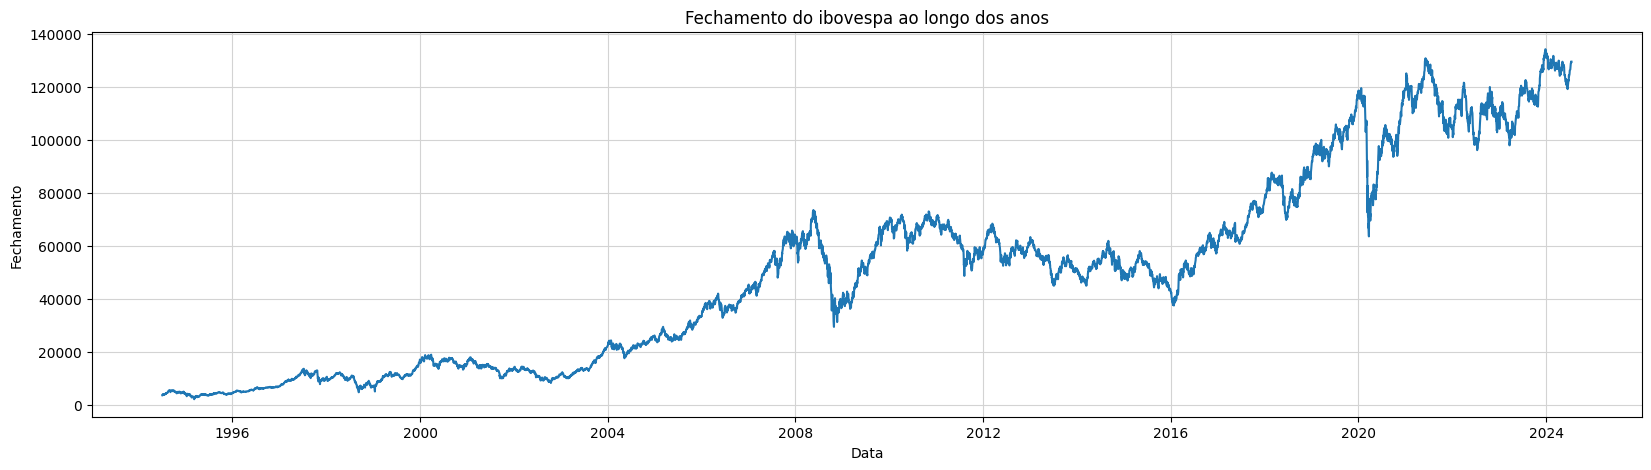

In [150]:
#Vamos analisar a variação do valor ao longo dos anos
#Criando o gráfico de linhas para analisar se temos grandes mudanças ao longo do tempo na média de segundos ativos no checkout
fig, ax = plt.subplots(figsize=(20, 5)) #indica o tamanho do gráfico
ax.grid(True, color='lightgray') #Coloca as linhas de grade
sns.lineplot(x='Data', y='Fechamento', data=df_ibovespa) #cria o gráfico de linhas
ax.set_title('Fechamento da ibovespa ao longo dos anos') #título do gráfico
plt.show() #mostrando o gráfico

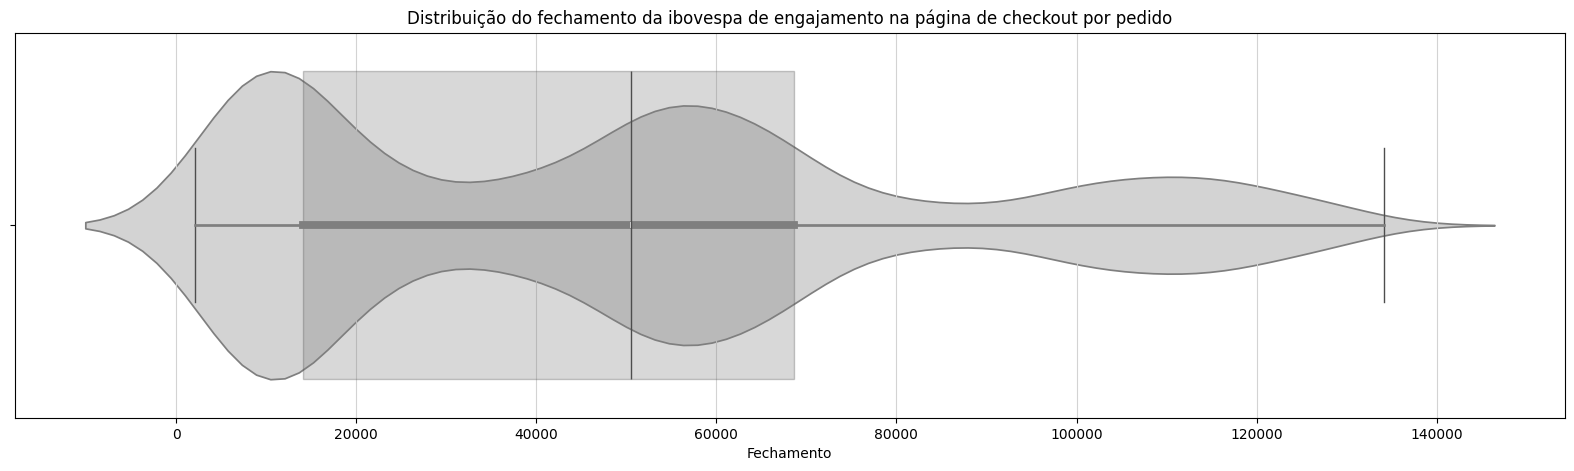

In [156]:
#Vamos analisar a distribuição desses dados com o violinplot, mesclado com o boxplot
fig, ax = plt.subplots(figsize=(20,5)) #indica o tamanho do gráfico
ax.grid(True, color='lightgray') #Coloca as linhas de grade
sns.boxplot(data=df_ibovespa, x='Fechamento', color='gray', boxprops=dict(alpha=.3)) #criando o boxplot
sns.violinplot(data=df_ibovespa, x='Fechamento', color='lightgray') #criando o violinplot
ax.set_title("Distribuição do fechamento da ibovespa de engajamento na página de checkout por pedido") #Título do gráfico
plt.show() #mostrando o gráfico

Como podemos ver, nossos dados são muito distantes entre si. O motivo disso é claro: o valor de uma ação ao longo dos anos sofre o aumento da inflação.